In [1]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

#### Weave automaically tracks call to common LLM libraries like openai, anthropic, cohere and mistral

In [2]:
import weave

from openai import OpenAI
client = OpenAI()

# Initialize Weave Tracing
weave.init('tracing-sandbox')

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {
            "role": "user",
            "content": "How are you?"
        }
    ],
    temperature=0.8,
    max_tokens=64,
    top_p=1,
)

Logged in as Weights & Biases user: paul-mriganka.
View Weave data at https://wandb.ai/paul-mriganka-personal/tracing-sandbox/weave
🍩 https://wandb.ai/paul-mriganka-personal/tracing-sandbox/r/call/019686f7-54f9-78f0-88e2-2477391f4346


#### Decorating and wrapping functions

In [4]:
import weave

# Initialize Weave Tracing
weave.init("tracing-sandbox")

class MyClass:
    # Decorate your method
    @weave.op
    def my_method(self, name: str):
        return f"Hello, {name}!"

instance = MyClass()

# Call your method -- Weave will automatically track inputs and outputs
print(instance.my_method("World"))

Logged in as Weights & Biases user: paul-mriganka.
View Weave data at https://wandb.ai/paul-mriganka-personal/tracing-sandbox/weave
Hello, World!
🍩 https://wandb.ai/paul-mriganka-personal/tracing-sandbox/r/call/019686fa-d8bf-7431-87dd-5dc483cdd0e5
🍩 https://wandb.ai/paul-mriganka-personal/tracing-sandbox/r/call/019686fd-436c-7911-9d29-d97fefaa2285
🍩 https://wandb.ai/paul-mriganka-personal/tracing-sandbox/r/call/019686fd-498d-7831-b53c-cc47f22874d7
🍩 https://wandb.ai/paul-mriganka-personal/tracing-sandbox/r/call/019686fd-a88a-78a0-a067-b57fc960241e
🍩 https://wandb.ai/paul-mriganka-personal/tracing-sandbox/r/call/01968700-c8b4-7643-97e6-7299a7930cf9
🍩 https://wandb.ai/paul-mriganka-personal/tracing-sandbox/r/call/01968701-81d1-7e80-98e3-4c3781cd7562


#### Getting a handle to the call object during execution

In [6]:
import weave

# Initialize Weave Tracing
weave.init('tracing-sandbox')

# Decorate your function
@weave.op
def my_function(name: str):
    return f"Hello, {name}!"

# Call your function -- Weave will automatically track inputs and outputs
print(my_function("World"))

Hello, World!


In [7]:
result, call = my_function.call("World")

In [8]:
print(instance.my_method.call(instance, "World"))

('Hello, World!', Call(_op_name=<Future at 0x7f595c0b0e50 state=pending>, trace_id='019686fd-a88a-78a0-a067-b561afe287f1', project_id='paul-mriganka-personal/tracing-sandbox', parent_id=None, inputs={'self': <__main__.MyClass object at 0x7f5974980880>, 'name': 'World'}, id='019686fd-a88a-78a0-a067-b57fc960241e', output='Hello, World!', exception=None, summary={}, _display_name=None, attributes=AttributesDict({'weave': {'client_version': '0.51.44', 'source': 'python-sdk', 'sys_version': '3.10.17 | packaged by conda-forge | (main, Apr 10 2025, 22:19:12) [GCC 13.3.0]', 'os_name': 'Linux', 'os_version': '#1 SMP Debian 5.10.234-1 (2025-02-24)', 'os_release': '5.10.0-34-cloud-amd64'}}), started_at=None, ended_at=datetime.datetime(2025, 4, 30, 13, 58, 12, 874329, tzinfo=datetime.timezone.utc), deleted_at=None, _children=[], _feedback=None))


#### Call display name

In [9]:
# Change the display name at the time of calling the op:
result = my_function("World", __weave={"display_name": "My Custom display name"})

In [10]:
# Method2
result, call = my_function.call("World")
call.set_display_name("My Custom Display Name")

In [11]:
# Method 3
# @weave.op(call_display_name="My Custom Display Name")
# def my_function(name: str):
#     return f"Hello, {name}!"

#### Adding Custom cost

In [13]:
import weave
from datetime import datetime

client = weave.init("my_custom_cost_model")

client.add_cost(
    llm_id="your_model_name",
    prompt_token_cost=0.01,
    completion_token_cost=0.02
)

client.add_cost(
    llm_id="your_model_name",
    prompt_token_cost=10,
    completion_token_cost=20,
    # If for example I want to raise the price of the model after a certain date
    effective_date=datetime(2026, 4, 22),
)

CostCreateRes(ids=[('0196870c-4faa-78f1-9e20-eab0c1407ee5', 'your_model_name')])

#### Querying for costs

In [14]:
import weave

client = weave.init("my_custom_cost_model")
costs = client.query_costs(llm_ids=["your_model_name"])
cost = client.query_costs(costs[0].id)

In [15]:
cost

[CostQueryOutput(id='0196870c-4faa-78f1-9e20-eab0c1407ee5', llm_id='your_model_name', prompt_token_cost=10.0, completion_token_cost=20.0, prompt_token_cost_unit='USD', completion_token_cost_unit='USD', effective_date=datetime.datetime(2026, 4, 22, 0, 0), provider_id='default')]

#### Purging a custom cost

In [16]:
import weave

client = weave.init("my_custom_cost_model")

costs = client.query_costs(llm_ids=["your_model_name"])
client.purge_costs([cost.id for cost in costs])

#### Calculating costs for a project

In [18]:
import weave

weave.init("functionbased-example")
@weave.op()
def get_costs_for_project(project_name: str):
    total_cost = 0
    requests = 0

    client = weave.init(project_name)
    # Fetch all the calls in the project
    calls = list(
        client.get_calls(filter={"trace_roots_only": True}, include_costs=True)
    )

    for call in calls:
        # If the call has costs, we add them to the total cost
        if call.summary["weave"] is not None and call.summary["weave"].get("costs", None) is not None:
            for k, cost in call.summary["weave"]["costs"].items():
                requests += cost["requests"]
                total_cost += cost["prompt_tokens_total_cost"]
                total_cost += cost["completion_tokens_total_cost"]

    # We return the total cost, requests, and calls
    return {
        "total_cost": total_cost,
        "requests": requests,
        "calls": len(calls),
    }

# Since we decorated our function with @weave.op(),
# our totals are stored in weave for historic cost total calculations
get_costs_for_project("functionbased-example")

Logged in as Weights & Biases user: paul-mriganka.
View Weave data at https://wandb.ai/paul-mriganka-personal/functionbased-example/weave
🍩 https://wandb.ai/paul-mriganka-personal/functionbased-example/r/call/01968718-cf2d-7910-a89b-4a7e6c02bd77


{'total_cost': 0.0155499996085382, 'requests': 15, 'calls': 10}

#### Integration

In [19]:
name_of_wandb_project = "custom-cost-model"

In [20]:
weave_client = weave.init(name_of_wandb_project)

Logged in as Weights & Biases user: paul-mriganka.
View Weave data at https://wandb.ai/paul-mriganka-personal/custom-cost-model/weave


In [24]:
from weave import Model

class YourModel(Model):
    attribute1: str
    attribute2: int
    
    def simple_token_count(self, text: str) -> int:
        return len(text) // 3
    
    # This is a custom op
    # It takes a string, and outputs a dict with the usage counts, model name and the output
    @weave.op()
    def custom_model_generate(self, input_data: str) -> dict:
        # Model logic goes here
        # Here the custom generate function would be there
        prediction = self.attribute1 + " " + input_data
        
        # Usage count
        prompt_tokens = self.simple_token_count(input_data)
        completion_tokens = self.simple_token_count(prediction)
        
        # We return a dictionary with the usage counts, model name and the output
        # Weave will automatically asscoiate with the trace
        # The object {usage, model, output} matches the output of a OpenAI call
        return {
             "usage": {
                "input_tokens": prompt_tokens,
                "output_tokens": completion_tokens,
                "total_tokens": prompt_tokens + completion_tokens,
            },
            "model": "your_model_name",
            "output": prediction,
        }

    # In our predict function we call our custom generate function, and return the output.
    @weave.op()
    def predict(self, input_data: str) -> dict:
        # Here is where you would do any post processing of the data
        outputs = self.custom_model_generate(input_data)
        return outputs["output"]

In [25]:
model = YourModel(attribute1="Hello", attribute2=1)
model.predict("world")
# We then add a custom cost to our project
weave_client.add_cost(
    llm_id="your_model_name", prompt_token_cost=0.1, completion_token_cost=0.2
)

# We can then query for the calls, and with include_costs=True
# we receive the costs back attached to the calls
calls = weave_client.get_calls(filter={"trace_roots_only": True}, include_costs=True)

list(calls)

🍩 https://wandb.ai/paul-mriganka-personal/custom-cost-model/r/call/01968735-583d-7021-ad27-514b5ca03c85


[WeaveObject(Call(_op_name='weave:///paul-mriganka-personal/custom-cost-model/op/YourModel.predict:NpWYTb8xXYErwikUiWHzvgJPqXdOAOCQ816AXvr0OHI', trace_id='01968735-583d-7021-ad27-513b3ab5cf0d', project_id='paul-mriganka-personal/custom-cost-model', parent_id=None, inputs={'self': ObjectRef(entity='paul-mriganka-personal', project='custom-cost-model', name='YourModel', _digest='nKk4BREZdxuvHwm3LxZsx1hdueU6bX2qHHc55fGT9gE', _extra=()), 'input_data': 'world'}, id='01968735-583d-7021-ad27-514b5ca03c85', output='Hello world', exception=None, summary={'usage': {'your_model_name': {'input_tokens': 1, 'output_tokens': 3, 'requests': 1, 'total_tokens': 4}}, 'weave': {'status': <TraceStatus.SUCCESS: 'success'>, 'trace_name': 'YourModel.predict', 'latency_ms': 1, 'costs': {'your_model_name': {'prompt_tokens': 1, 'completion_tokens': 3, 'requests': 1, 'total_tokens': 4, 'prompt_tokens_total_cost': 0.10000000149011612, 'completion_tokens_total_cost': 0.6000000089406967, 'prompt_token_cost': 0.1, 'c

### Logging media

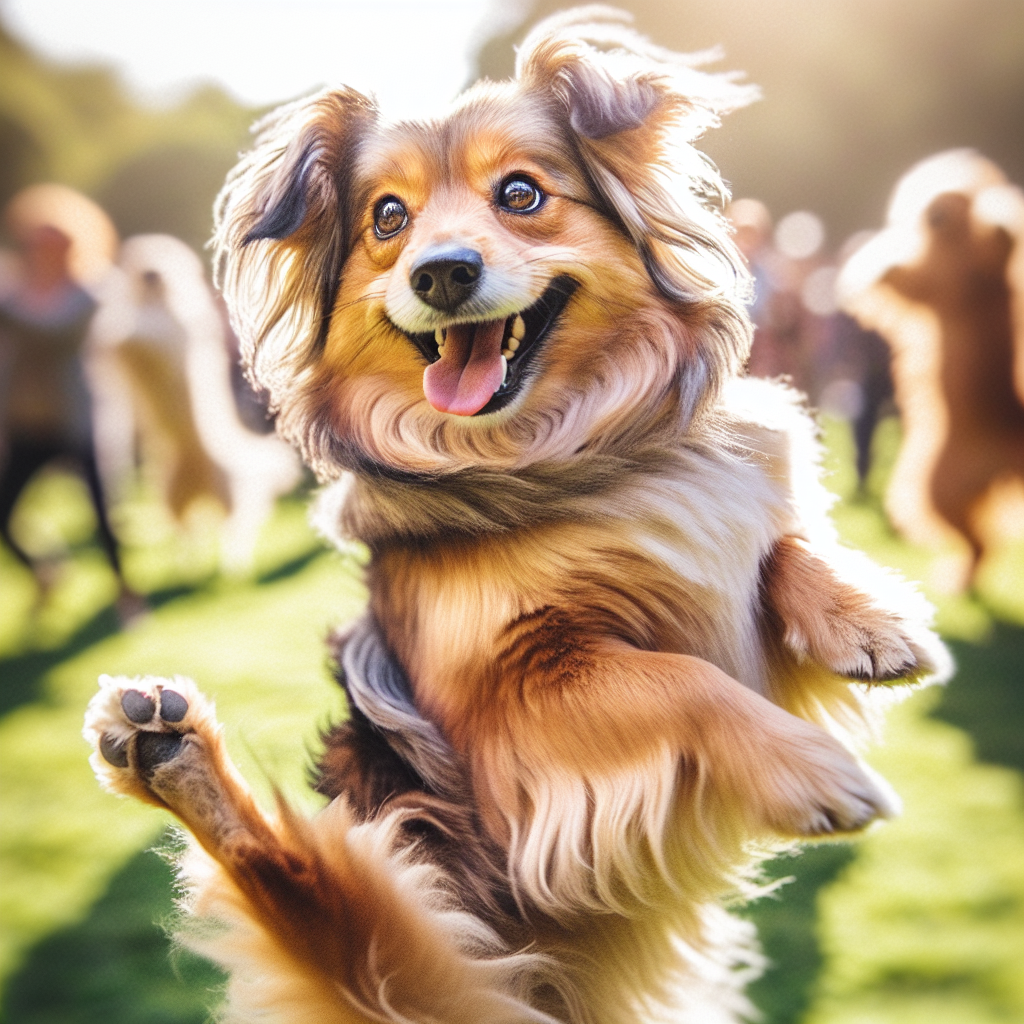

In [27]:
import weave
from openai import OpenAI
import requests
from PIL import Image

weave.init('image-example')
client = OpenAI()

@weave.op
def generate_image(prompt: str) -> Image:
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1,
    )
    image_url = response.data[0].url
    image_response = requests.get(image_url, stream=True)
    image = Image.open(image_response.raw)

    # return a PIL.Image.Image object to be logged as an image
    return image

generate_image("a dancing dog")